# Cohort 60x60 AUCs analysis

### Imports and environment setup

- Date of run: 2024-08-13
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [1]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [2]:
# Library imports
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

# Utils imports
import cohort_analysis_utils as utils

In [3]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)


# Data loading and preprosessing

The original excel file (available [here](<https://mimarkdx.sharepoint.com/sites/Scientific/Documentos compartidos/General/PHASE 6 - SOFTWARE DEVELOPMENT/DATA/../../../../../../:x:/s/Scientific/Eaw9d-fa2BREg_iZB1SL02YBG4mfVaJtoylG46bROmXVJA?e=8chcN7>)) was saved into a CSV file in the data folder of this repository, separating fields by TABs.

In [4]:
df_120 = pd.read_csv('../data/60x60_dr_ruo_20241209.csv' , sep='\t', index_col=0, header=0)


In [5]:
# Harmonization of column names
df_120 = utils.normalize_column_names(df_120)

In [6]:
# Ensure numeric columns are treated as such
cols_120_to_num = ['Collected_volume_mL', 'pH',
                    'MMP9', 'HSPB1', 'PERM', 'ADIPOQ', 'TIMP-2', 'AGRIN', 'KPYM' 'Total_protein_BCA',
                    'Total_protein_BCA']
df_120 = utils.cols_as_numbers(df_120, cols_120_to_num)

Could not convert KPYMTotal_protein_BCA to float
'KPYMTotal_protein_BCA'


In [7]:
# Columns to be considered as biomarkers
BIOMARKERS_120 = ['MMP9', 'HSPB1', 'PERM', 'ADIPOQ', 'TIMP-2', 'AGRIN', 'KPYM']


In [8]:
# Create new columns with the ratios between the biomarkers
for biomarker1 in BIOMARKERS_120:
    for biomarker2 in BIOMARKERS_120:
        if biomarker1 != biomarker2:
            df_120[f'{biomarker1}_{biomarker2}'] = df_120[biomarker1].div(df_120[biomarker2], axis=0)
            # Make infinite values NaN
            df_120[f'{biomarker1}_{biomarker2}'] = df_120[f'{biomarker1}_{biomarker2}'].replace([np.inf, -np.inf], np.nan)
    

In [9]:
# Ensure categorical columns are treated as such
df_120 = utils.cols_as_category(df_120, {'Pathology':{'Benign': 0, 'Endometrial cancer': 1}})

# Execution parameters

In [10]:
PLOT_ROCS = True
MAX_BIOMARKER_COUNT = 4
RESULTS_PATH = '../data/results/60x60_dr_ratios_ruo'

# The biomarkers now include the ratios
BIOMARKERS_120 = [f"{biomarker1}_{biomarker2}" for biomarker1 in BIOMARKERS_120 for biomarker2 in BIOMARKERS_120 if biomarker1 != biomarker2]

NORMALIZING_COL_120 = 'Total_protein_BCA' # Column to be used for normalizing the biomarkers
VOLUME_COL = 'Collected_volume_mL' # Column to be used as volume for scatters and undoing the dilution

In [11]:
METHODS = ['direct']

In [12]:
# how many rows have defined values for biomarkers "MMP9", "HSPB1", "ADIPOQ", "PERM" & "TIMP-2"
df_120_defined = df_120.dropna(subset=["MMP9_HSPB1","HSPB1_ADIPOQ","PERM_ADIPOQ","ADIPOQ_MMP9","TIMP-2_PERM"])

In [13]:
df_120_defined.shape

(41, 64)

In [14]:
# Count the number of samples for each pathology
df_120_defined['Pathology'].value_counts()

Pathology
0    22
1    19
Name: count, dtype: int64

# Computing the models

All the functions to generate the models are included in the [cohort_analysis_utils.py](../code/cohort_analysis_utils.py) file.

In [15]:
for MAX_BIOMARKER_COUNT in range(2, 5):
    print(f"Computing models with {MAX_BIOMARKER_COUNT} biomarkers")
    models_120 = utils.compute_all_models_and_save(
                                df=df_120,
                                biomarkers=BIOMARKERS_120,
                                normalizing_col=NORMALIZING_COL_120, 
                                volume_col= VOLUME_COL,
                                volume_added=0.5,
                                apply_log=True,
                                avoid_same_biomarker=True,
                                methods=METHODS,
                                max_biomarker_count=MAX_BIOMARKER_COUNT,
                                folder_name=RESULTS_PATH,
                                plot_rocs=PLOT_ROCS,
                                auc_threshold=0.95,
                                )

Computing models with 2 biomarkers


Computing models with 3 biomarkers
Computing models with 4 biomarkers
Could not fit the model for biomarkers: ['HSPB1_TIMP-2', 'ADIPOQ_KPYM', 'TIMP-2_MMP9', 'KPYM_MMP9']
Singular matrix
Could not fit the model for biomarkers: ['HSPB1_AGRIN', 'ADIPOQ_KPYM', 'TIMP-2_MMP9', 'KPYM_MMP9']
Singular matrix
Could not fit the model for biomarkers: ['ADIPOQ_KPYM', 'TIMP-2_MMP9', 'AGRIN_HSPB1', 'KPYM_MMP9']
Singular matrix


Let's do the same for single biomarkers.

In [16]:
MAX_BIOMARKER_COUNT = 1

models_120_1 = utils.compute_all_models_and_save(
                            df=df_120,
                            biomarkers=BIOMARKERS_120,
                            normalizing_col=NORMALIZING_COL_120, 
                            volume_col= VOLUME_COL,
                            volume_added=0.5,
                            apply_log=True,
                            avoid_same_biomarker=True,
                            methods=METHODS,
                            max_biomarker_count=MAX_BIOMARKER_COUNT,
                            folder_name=RESULTS_PATH,
                            plot_rocs=PLOT_ROCS,
                            compute_auc_ci=True
                            )

# Results

## Direct

Here are presented the top 10 results for the direct method. Remember you can see the full results [here](<../data/results/60x60/direct/max_3.csv>) (they are stored in the folder "data/results/60x60/direct/").

Let's see also how the biomarkers performed individually.

## Undo dilution

## AUCs confidence interval

AUCs confidence intervals are computed with the bootstraping method. Bootstrapping to compute confidence intervals for AUC involves repeatedly resampling the original dataset with replacement to create many bootstrap samples, calculating the AUC for each sample, and then constructing a distribution of these AUC values. The confidence interval is determined by taking the appropriate percentiles (e.g., 2.5th and 97.5th for a 95% CI) from the sorted bootstrap AUC values, providing a range that estimates where the true AUC likely falls.

In [17]:
aucs = []
auc_cis = []
models = []

for model in models_120_1['direct'][(list(models_120_1['direct'].keys())[0])].keys():
    model_name = model[0]
    model_auc = models_120_1['direct'][(list(models_120_1['direct'].keys())[0])][model]['auc']
    model_auc_ci = models_120_1['direct'][(list(models_120_1['direct'].keys())[0])][model]['auc_ci']
    aucs.append(float(model_auc))
    auc_cis.append([float(model_auc_ci[0]), float(model_auc_ci[1])])
    models.append(model_name)

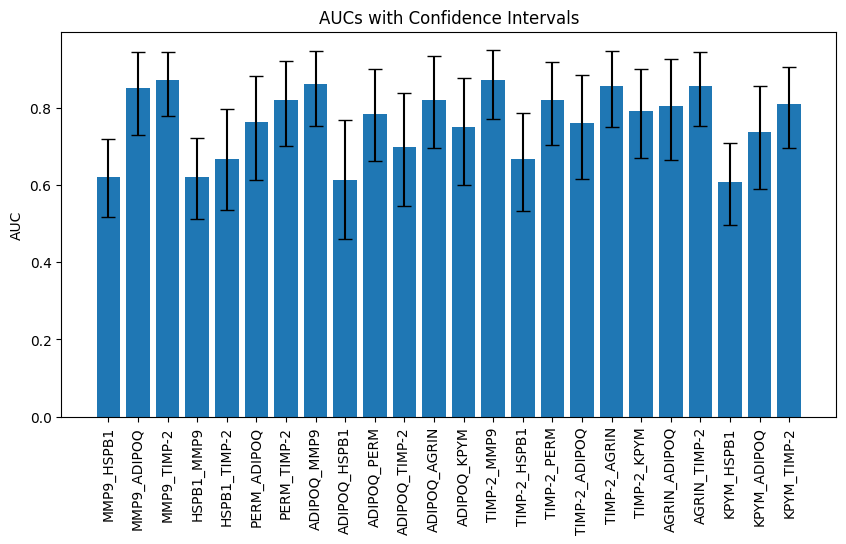

In [18]:
auc_cis = np.array(auc_cis)

# Calculate the errors
lower_err = aucs - auc_cis[:, 0]
upper_err = auc_cis[:, 1] - aucs
yerr = [lower_err, upper_err]

plt.figure(figsize=(10,5))
plt.bar(models, aucs, yerr=yerr, capsize=5, align='center')
plt.xticks(rotation=90)
plt.ylabel('AUC')
plt.title('AUCs with Confidence Intervals')
plt.show()